<a href="https://colab.research.google.com/github/donyeun/AMLSII_19-20_SN18154195/blob/master/AMLS_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Libraries and Variables

In [0]:
import pandas as pd
import os
import torch
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import csv

In [0]:
cfg = {
       'paths': {
           'train_folder_task_a': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/training/2017_English_final/GOLD/Subtask_A',
           'train_additional_dataset_filenames': ['livejournal-2014test-A.tsv', 'sms-2013test-A.tsv'],
           'test_file_task_a': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/testing/SemEval2017-task4-test/SemEval2017-task4-test.subtask-A.english.txt',

           'train_folder_task_b': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/training/2017_English_final/GOLD/Subtasks_BD',
           'test_file_task_b': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/testing/SemEval2017-task4-test/SemEval2017-task4-test.subtask-BD.english.txt',
       },
       'task_a': {
           'use_additional_dataset': False,
           'dataset': {
               'clean' : {
                   'training_filepath': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/clean/task_a_training.csv'
               }
           }
       },
       'preprocessing': {
           'tokenization': {
               'remove_twitter_handle': True,
               'preserve_case': False
           }
       },
}

# Load Dataset and Data Preprocessing

## Preprocess Additional Dataset
In task A, there are some additional datasets that were given from the competition apart from the standard twitter corpus, which is sms and livejournal corpus. We can use both of these additional datasets, after we preprocess the formatting so that it matches the rest of the twitter datasets.

In [4]:
task_a_train_additional_dfs = {}

for filename in cfg['paths']['train_additional_dataset_filenames']:
  # read additional corpora
  task_a_train_additional_dfs[filename] = pd.read_csv(os.path.join(cfg['paths']['train_folder_task_a'], filename), sep='\t', header=None, quoting=csv.QUOTE_NONE)
  
  if filename == 'livejournal-2014test-A.tsv':
    # remove the 0-th column from livejournal corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[0])
  elif filename == 'sms-2013test-A.tsv':
    # remove the 1st column from sms corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[1])
  
  # reset the column index to make it incremental
  task_a_train_additional_dfs[filename].columns = range(task_a_train_additional_dfs[filename].shape[1])
  
  print(task_a_train_additional_dfs[filename])

             0         1                                                  2
0     LJ111111  negative  I know I missed something here , but what does...
1     LJ111113   neutral  What do you think of Beside Ourselves as a tit...
2     LJ111114  positive                    :D I intend to be one someday .
3     LJ111117  negative  LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4     LJ111119   neutral                     LLLINKKK Some more mountains .
...        ...       ...                                                ...
1137  LJ113616  positive                     Maybe it was - his - fantasy ?
1138  LJ113618  negative  It was ok , but they always just seem so nervo...
1139  LJ113621  positive  It is streamable from YepRoc -- matter of fact...
1140  LJ113623  positive  comment telling me who you are , or how you fo...
1141  LJ113625   neutral  im on myspace ... ill try and find you and add...

[1142 rows x 3 columns]
          0         1                                          

## Make Datasets As Pandas' DataFrames and Cleaning Dataset



In [0]:
def append_txt_files_as_one_dataframe(folderpath, filename_keywords_list, additional_dataset_dfs=None):
  dataset_per_file_dfs = {}
  dataset_df = pd.DataFrame()
  filenames = os.listdir(folderpath)
  
  # open txt files (in tsv formatting)
  for filename in filenames:
    # if the filename contains a keyword in the filename_keywords_list, then open the txt file
    # this is to avoid opening unnecessary txt such as readme.txt file.
    if any(keyword in filename for keyword in filename_keywords_list):
      dataset_per_file_dfs[filename] = pd.read_csv(os.path.join(folderpath, filename), sep="\t", header=None, quoting=csv.QUOTE_NONE)
      print(dataset_per_file_dfs[filename].shape, filename)

  # combine the original dataset with additional dataset (if any)
  if additional_dataset_dfs is not None:
    for key, value in additional_dataset_dfs.items():
      dataset_per_file_dfs[key] = value

  # append all the files as one dataframe
  for key, value in dataset_per_file_dfs.items():
    # print(key, '\t', i, '\t', dataset_per_file_df[key].shape[0])
    dataset_df = dataset_df.append(dataset_per_file_dfs[key], ignore_index=True)
  return dataset_df

In [0]:
def clean_dataframe_format(df, new_column_name_list, drop_column_list=[]):
  # drop unnecessary column
  df = df.drop(columns=drop_column_list)
  
  # rename column
  df.columns = new_column_name_list

  # remove row in dataframe if the 'text' or 'sentiment' column value is missing
  df = df.dropna(subset=['sentiment', 'text'], how='any').reset_index(drop=True)
  
  # remove row if the sentiment is not 'positive', 'negative' or 'neutral'
  # this happens in the dataset, for example, there are some rows
  # where its sentiments are 'off topic'
  valid_sentiments = ['positive', 'negative', 'neutral']
  df = df[df['sentiment'].isin(valid_sentiments)].reset_index(drop=True)
  return df

In [7]:
# read dataset files and append it as one pandas dataframe
if cfg['task_a']['use_additional_dataset']:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'], task_a_train_additional_dfs)
else:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'])

task_a_train_df = clean_dataframe_format(task_a_train_df, ['id', 'sentiment', 'text'], drop_column_list=[3])

# # save dataset as csv file
# with pd.option_context('display.max_columns', None):  # more options can be specified also
#     print(task_a_train_df)

# print(task_a_train_df.shape)

(2000, 3) twitter-2016devtest-A.txt
(1999, 3) twitter-2016dev-A.txt
(6000, 3) twitter-2016train-A.txt
(1654, 3) twitter-2013dev-A.txt
(3547, 3) twitter-2013test-A.txt
(9684, 3) twitter-2013train-A.txt
(1853, 3) twitter-2014test-A.txt
(2390, 3) twitter-2015test-A.txt
(489, 3) twitter-2015train-A.txt
(86, 3) twitter-2014sarcasm-A.txt
(20633, 4) twitter-2016test-A.txt


In [8]:
task_b_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_b'], ['twitter'])
task_b_train_df = clean_dataframe_format(task_b_train_df, ['id', 'topic','sentiment', 'text'], drop_column_list=[4])
task_b_train_df.info()

(4346, 4) twitter-2016train-BD.txt
(1325, 4) twitter-2016dev-BD.txt
(1417, 4) twitter-2016devtest-BD.txt
(489, 4) twitter-2015train-BD.txt
(10552, 5) twitter-2016test-BD.txt
(2383, 5) twitter-2015testBD.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20508 entries, 0 to 20507
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20508 non-null  object
 1   topic      20508 non-null  object
 2   sentiment  20508 non-null  object
 3   text       20508 non-null  object
dtypes: object(4)
memory usage: 641.0+ KB


In [9]:
print(task_b_train_df[
                (task_b_train_df['sentiment'] != 'negative') &
                (task_b_train_df['sentiment'] != 'positive') &
                (task_b_train_df['sentiment'] != 'neutral')
                ]['sentiment'])

# task_b_train_df

# task_b_train_df[task_b_train_df['text'].str.len()< 40]

Series([], Name: sentiment, dtype: object)


In [10]:
task_a_test_df = pd.read_csv(cfg['paths']['test_file_task_a'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_a_test_df = clean_dataframe_format(task_a_test_df, ['id', 'sentiment', 'text'])
task_a_test_df

,id,sentiment,text
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
...,...,...,...
12279,805699615781625856,positive,@dansen17 update: Zac Efron kissing a puppy ht...
12280,805701709356003328,neutral,#zac efron sex pic skins michelle sex https://...
12281,805701818357579776,neutral,First Look at Neighbors 2 with Zac Efron Shirt...
12282,805703557081075712,neutral,zac efron poses nude #lovely libra porn https:...


In [11]:
task_b_test_df = pd.read_csv(cfg['paths']['test_file_task_b'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_b_test_df = clean_dataframe_format(task_b_test_df, ['id', 'topic', 'sentiment', 'text'])
task_b_test_df

,id,topic,sentiment,text
0,801989272341453952,#ArianaGrande,positive,Ariana Grande KIIS FM Yours Truly CD listening...
1,801990978424962944,#ArianaGrande,positive,Ariana Grande White House Easter Egg Roll in W...
2,801996232553963008,#ArianaGrande,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
3,801998343442407040,#ArianaGrande,positive,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
4,802001659970744064,#ArianaGrande,positive,Hairspray Live! Previews at the Macy's Thanksg...
...,...,...,...,...
6180,805696468959002624,zac efron,positive,"Abby *talking about the Hamilton soundtrack"": ..."
6181,805699412257181697,zac efron,positive,can we like get zac efron or justin bieber for...
6182,805699615781625856,zac efron,positive,@dansen17 update: Zac Efron kissing a puppy ht...
6183,805701818357579776,zac efron,positive,First Look at Neighbors 2 with Zac Efron Shirt...


In [0]:
# Checking and compare the frequency with what's written in the paper
# # save dataset as csv file
# task_a_train_df.to_csv('coba_train_a.csv', sep='\t')

# assert task_a_train_df[task_a_train_df['sentiment'] == 'positive'].shape[0] == 19902  #SALAH
assert task_a_train_df[task_a_train_df['sentiment'] == 'negative'].shape[0] == 7840
assert task_a_train_df[task_a_train_df['sentiment'] == 'neutral'].shape[0] == 22591

assert task_a_test_df[task_a_test_df['sentiment'] == 'positive'].shape[0] == 2375
assert task_a_test_df[task_a_test_df['sentiment'] == 'negative'].shape[0] == 3972
assert task_a_test_df[task_a_test_df['sentiment'] == 'neutral'].shape[0] == 5937

assert len(task_b_train_df['topic'].unique()) == 373
assert task_b_train_df[task_b_train_df['sentiment'] == 'positive'].shape[0] == 14951
assert task_b_train_df[task_b_train_df['sentiment'] == 'negative'].shape[0] == 4013
assert task_b_train_df[task_b_train_df['sentiment'] == 'neutral'].shape[0] == 1544


assert len(task_b_test_df['topic'].unique()) == 125
assert task_b_test_df[task_b_test_df['sentiment'] == 'positive'].shape[0] == 2463
assert task_b_test_df[task_b_test_df['sentiment'] == 'negative'].shape[0] == 3722

## Tokenization

In [0]:
def tokenize_df(df, tokenizer, input_column_name='text', output_column_name='tokenized'):
  df[output_column_name] = df.apply(
    lambda row: tokenizer.tokenize(
        row[input_column_name]
    ),
    axis=1)
  return df

In [14]:
tokenizer = nltk.tokenize.TweetTokenizer(
    strip_handles = cfg['preprocessing']['tokenization']['remove_twitter_handle'],
    preserve_case = cfg['preprocessing']['tokenization']['preserve_case']
)

task_a_train_df = tokenize_df(task_a_train_df, tokenizer)
task_b_train_df = tokenize_df(task_b_train_df, tokenizer)
task_a_test_df = tokenize_df(task_a_test_df, tokenizer)
task_b_test_df = tokenize_df(task_b_test_df, tokenizer)


# print sample result
task_b_test_df.head(10)

,id,topic,sentiment,text,tokenized
0,801989272341453952,#ArianaGrande,positive,Ariana Grande KIIS FM Yours Truly CD listening...,"[ariana, grande, kiis, fm, yours, truly, cd, l..."
1,801990978424962944,#ArianaGrande,positive,Ariana Grande White House Easter Egg Roll in W...,"[ariana, grande, white, house, easter, egg, ro..."
2,801996232553963008,#ArianaGrande,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,"[#cd, #musics, ariana, grande, sweet, like, ca..."
3,801998343442407040,#ArianaGrande,positive,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,"[side, to, side, 😘, #sidetoside, #arianagrande..."
4,802001659970744064,#ArianaGrande,positive,Hairspray Live! Previews at the Macy's Thanksg...,"[hairspray, live, !, previews, at, the, macy's..."
5,802003380973568000,#ArianaGrande,positive,#LindsayLohan Is ‘Feeling Thankful’ After Blas...,"[#lindsaylohan, is, ‘, feeling, thankful, ’, a..."
6,802014830467174016,#ArianaGrande,negative,I hate her but... I love her songs Dammit ._.#...,"[i, hate, her, but, ..., i, love, her, songs, ..."
7,802022559520673024,#ArianaGrande,positive,My idols are #littlemix #justinbieber #arianag...,"[my, idols, are, #littlemix, #justinbieber, #a..."
8,802024085777629056,#ArianaGrande,positive,#Beauty #ArianaGrande-CHRISTMAS & CHILL-JAPAN ...,"[#beauty, #arianagrande-christmas, &, chill-ja..."
9,802028835013206016,#ArianaGrande,positive,#Beauty #ArianaGrande-THE REMIX-JAPAN ONLY #CD...,"[#beauty, #arianagrande-the, remix-japan, only..."


# Exploratory Data Analysis (EDA)

## Word Cloud

In [0]:
def show_wordcloud(text, title, max_words=200):
  wc = WordCloud(
      max_words=max_words,
      background_color='white',
      # ranks_only= frequency
  ).generate(text)

  print(wc.words_)

  fig = plt.figure(1, figsize=(12, 12))
  fig.suptitle(title)
  plt.imshow(wc)
  plt.show()

Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft
<class 'str'>
{'verse': 1.0, 'wrote': 1.0, 'book': 1.0, 'stand': 1.0, 'titlea': 1.0, 'kampung': 1.0}


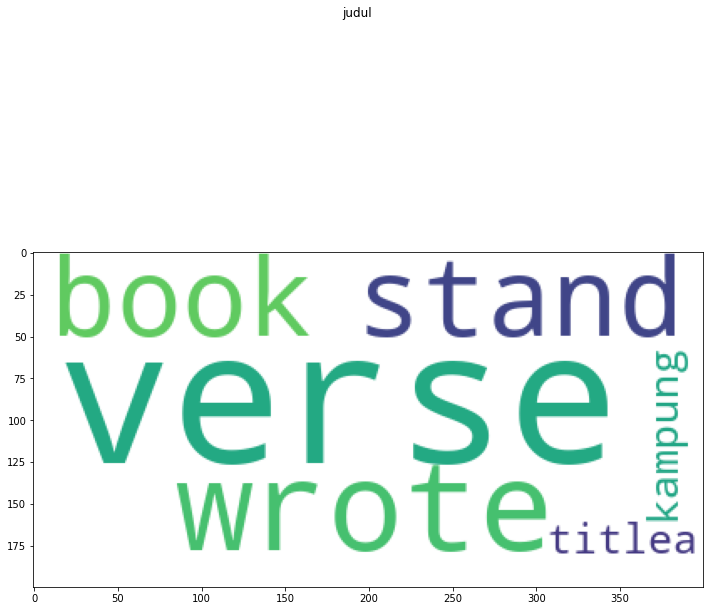

In [16]:
df = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['text'][4]
print(df)
# print(df.shape)
# show_wordcloud(str(df.values), 'judul', max_words=20000)

# print(df.shape)
word_string = "you verse wrote book stand titlea i you you you kampung"
print(type(word_string))
show_wordcloud(word_string, 'judul', max_words=20000)

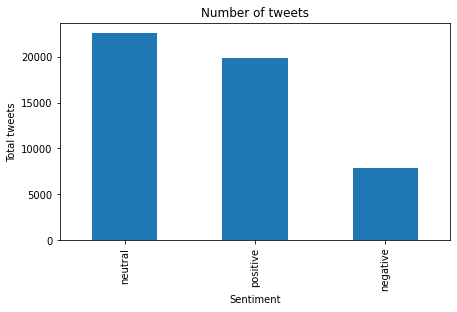

In [17]:
task_a_train_df['sentiment'].value_counts().plot(kind='bar',figsize=(7,4));
plt.title('Number of tweets');
plt.xlabel('Sentiment');
plt.ylabel('Total tweets');

In [18]:
task_b_train_df[task_b_train_df['text'].str.contains('not')]

,id,topic,sentiment,text,tokenized
4,629226490152914944,@microsoft,positive,"Microsoft, I may not prefer your gaming branch...","[microsoft, ,, i, may, not, prefer, your, gami..."
8,629797991826722816,@microsoft,negative,"After attempting a reinstall, it still bricks,...","[after, attempting, a, reinstall, ,, it, still..."
16,631543121407442946,@microsoft,negative,@Microsoft support for 365 has been terrible. ...,"[support, for, 365, has, been, terrible, ., on..."
20,632536348419690496,@microsoft,negative,@eyesonfoxorg @Microsoft I'm still using Vista...,"[i'm, still, using, vista, on, one, &, win, -,..."
22,632810315227467776,@microsoft,negative,@MisterMetokur @Microsoft @ATT @NSAGov That's ...,"[that's, confidential, and, privileged, inform..."
...,...,...,...,...,...
20474,520384978820296705,yougov,negative,"""@LouiseBaldock great work; you may or may not...","["", great, work, ;, you, may, or, may, not, ha..."
20476,519600072971927555,yougov,neutral,"""YouGov tonight shows 2% Labour lead. So head...","["", yougov, tonight, shows, 2, %, labour, lead..."
20481,519201436102848512,yougov,neutral,IF tonight's YouGov shows another Tory lead th...,"[if, tonight's, yougov, shows, another, tory, ..."
20488,520337071345795073,yougov,neutral,"""Tonight's YouGov: Lab 35, Con 30, UKIP 15, Li...","["", tonight's, yougov, :, lab, 35, ,, con, 30,..."


                       positive  negative  neutral
randy orton                  36       7.0      NaN
kpop                         67       9.0      NaN
school                        3      10.0      7.0
cate blanchett               41       2.0      NaN
harper                       18      41.0      NaN
disneyland                   92       2.0      NaN
federer                      75       1.0      NaN
disney                       12       1.0      7.0
seinfeld                     75       2.0      NaN
carlo ancelotti               9       3.0      7.0
vettel                        3       2.0     14.0
minecraft                    82       1.0      NaN
bbc                          36      16.0      NaN
russell wilson                3       4.0     10.0
chuck norris                 32       6.0      NaN
scott walker                 18      54.0      NaN
lexus                        70       5.0      NaN
bad blood                    49      17.0      NaN
modi                          6

<BarContainer object of 303 artists>

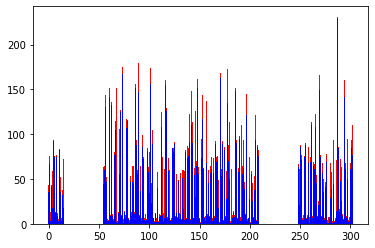

In [104]:
positive = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['topic'].value_counts(sort=False).to_frame(name='positive')
negative = task_b_train_df[task_b_train_df['sentiment'] == 'negative']['topic'].value_counts(sort=False).to_frame(name='negative')
neutral = task_b_train_df[task_b_train_df['sentiment'] == 'neutral']['topic'].value_counts(sort=False).to_frame(name='neutral')
# negative = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'negative'].value_counts(sort=False)
# neutral = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'neutral'].value_counts(sort=False)
joined = positive.join(negative).join(neutral)

joined = joined[(joined['positive'] > 0) & (joined['negative']>0)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(joined)

plt.bar(range(joined.shape[0]), joined['positive'], label='positive', color='blue')
plt.bar(range(joined.shape[0]), joined['negative'], label='negative', color='red', bottom=joined['positive'])

In [0]:
# # save dataset as csv file
# task_a_train_df.to_csv('coba_train_a', sep='\t')

# Pytorch

## Build Dataset


In [0]:
from torch.utils.data import DataLoader, Dataset
import csv

# class TextDataset(Dataset):
#   @staticmethod
#   def sort_key(ex):
#       return len(ex.text)

#   def __init__(self, dataset_df):
#     self.samples = []

#     for idx, row in dataset_df.iterrows():
#       if idx == 101:
#         break
#       self.samples.append( (row['text'], row['sentiment']) )

#   def __len__(self):
#     return len(self.samples)

#   def __getitem__(self, idx):
#     text, sentiment = self.samples[idx]
#     # return self.transform(self.x_data[index]), self.transform(self.y_data[index])
#     return (text, sentiment).ToTensor()

  

# task_a_trainset = TextDataset(task_a_train_df)
# dataloader = DataLoader(
#                 task_a_trainset,
#                 batch_size=50,
#                 num_workers=2
#              )

In [0]:
# for i, batch in enumerate(dataloader):
#   for sample in batch:
#     print(batch)
#   print(">>>>>>>")

# task_a_trainset

In [0]:
from torchtext import data



In [0]:
task_a_train_df = task_a_train_df[['text', 'sentiment']]
task_a_train_df.to_csv('train_a.csv', sep='\t', index=False)

task_a_test_df = task_a_test_df[['text', 'sentiment']]
task_a_test_df.to_csv('test_a.csv', sep='\t', index=False)


In [0]:
from sklearn.preprocessing import LabelEncoder

TEXT = data.Field(tokenize = 'spacy', lower=True, include_lengths=True)
# SENTIMENT = data.Field()
SENTIMENT = data.LabelField(dtype = torch.float)

train_data_a = data.TabularDataset(
    path='train_a.csv',
    format='tsv',
    fields = [('text', TEXT), ('sentiment', SENTIMENT)],
    skip_header=True
)

test_data_a = data.TabularDataset(
    path='test_a.csv',
    format='tsv',
    fields = [('text', TEXT), ('sentiment', SENTIMENT)],
    skip_header=True
)

# dataloader = DataLoader(
#                 train_data_a,
#                 batch_size=50,
#                 num_workers=2
#              )

In [0]:
# train_data_a_splitted = train_data_a.splits(TEXT, SENTIMENT)

In [114]:
vars(train_data_a.examples[0])

{'sentiment': 'neutral',
 'text': ['@seemonterey',
  'lost',
  '-',
  'sony',
  'cell',
  'phone',
  'with',
  'holiday',
  'photos',
  '.',
  'early',
  'fri',
  'morning',
  ',',
  'montreal',
  'transit',
  'plaza',
  'or',
  'no',
  '.',
  '13',
  'bus',
  'to',
  'airport',
  '.',
  'reward',
  '!',
  'plz',
  'rt',
  '.']}

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data_a, test_data_a), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [0]:
# train_iterator.text

## Build Vocabulary

In [0]:
SENTIMENT.build_vocab(train_data_a)

In [118]:
print(SENTIMENT.vocab.freqs.most_common())
for key, value in SENTIMENT.vocab.stoi.items():
  print(key, value)

[('neutral', 22591), ('positive', 19903), ('negative', 7840)]
neutral 0
positive 1
negative 2


In [119]:
TEXT.build_vocab(train_data_a,
                 max_size = 25000,
                 vectors = 'glove.twitter.27B.200d',
                 unk_init = torch.Tensor.normal_
                 )

print(TEXT.vocab.freqs.most_common(100))
print(TEXT.vocab.itos[:10])

[('the', 41746), ('"', 35287), ('.', 34027), ('to', 23100), (',', 19566), ('!', 18379), ('i', 18301), ('in', 15039), ('on', 14430), ('a', 14278), ('and', 14013), ('#', 12907), ('of', 11996), ('is', 10983), ('for', 10950), ('it', 9647), ('you', 9590), ("'s", 9548), ('with', 8354), ('...', 8232), ('be', 8067), (':', 7948), ('tomorrow', 7940), ('?', 7885), ('at', 7748), ('may', 7422), ('-', 7120), (' ', 5969), ('that', 5629), ('my', 5153), ('have', 5122), ('this', 4634), ('just', 4351), ('but', 4321), ('he', 4224), ('day', 4205), ('was', 4055), ('will', 4028), ("n't", 3995), ('not', 3408), ('so', 3349), ('going', 3336), ('we', 3331), ('me', 3277), ('all', 3261), ('&', 3247), ('night', 3225), ('out', 3219), ('if', 3183), ('see', 3111), ('friday', 2999), ('do', 2981), ('from', 2958), ('are', 2930), ('sunday', 2882), ('1st', 2881), (')', 2856), ('up', 2771), ('(', 2767), ('like', 2750), ('about', 2730), ('as', 2680), ('time', 2678), (';', 2577), ('get', 2489), ("'m", 2456), ('saturday', 2272

In [120]:
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])

[('the', 41746), ('"', 35287), ('.', 34027), ('to', 23100), (',', 19566), ('!', 18379), ('i', 18301), ('in', 15039), ('on', 14430), ('a', 14278), ('and', 14013), ('#', 12907), ('of', 11996), ('is', 10983), ('for', 10950), ('it', 9647), ('you', 9590), ("'s", 9548), ('with', 8354), ('...', 8232)]
['<unk>', '<pad>', 'the', '"', '.', 'to', ',', '!', 'i', 'in']


In [121]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(SENTIMENT.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 3


## Neural Network

three layers:
1. embedding layer (transform one-hot encoding vector into a dense embedding vector)
2. RNN
3. linear layer (output)

In [0]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
               bidirectional, dropout, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    # self.rnn = nn.RNN(embedding_dim, hidden_dim)
    self.rnn = nn.LSTM(embedding_dim,
                       hidden_dim,
                       num_layers=n_layers,
                       bidirectional=bidirectional,
                       dropout=dropout
                       )
    self.fully_connected = nn.Linear(hidden_dim*2, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, text_length):
    # text dimention is [sentence len, batch size]
    
    # embedded dimention is [sentence len, batch size, embedding_dim]
    embedded = self.dropout(self.embedding(text))

    # pack the sequence
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length)
    packet_output, (hidden, cell) = self.rnn(packed_embedded)

    # unpack the sequence
    output, output_length = nn.utils.rnn.pad_packed_sequence(packet_output)

    # output dimention is [sentence len, batch size, hidden dim * num directions]
    # output over padding tokens are zero tensors

    # hidden dimension is [num layers*num directions, batch size, hidden dim]
    # cell dimension is also [num layers*num directions, batch size, hidden dim]

    #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
    #and apply dropout

    # hidden dimension is [batch size, hid dim*num directions]
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    
    return self.fully_connected(hidden)


In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = len(SENTIMENT.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX,
            )

In [158]:
def count_model_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
  # n_params = sum(p.numel() for p in model.parameters)
  
print(model.parameters)
print(count_model_params(model))


<bound method Module.parameters of RNN(
  (embedding): Embedding(25002, 200, padding_idx=1)
  (rnn): LSTM(200, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fully_connected): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>
7516883


In [159]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 200])


In [160]:
# replace the initial weights of the embedding layer with the pretrained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.3199,  0.1071,  0.2892,  ...,  0.7315,  2.1747,  0.5568],
        [-0.4101, -0.7039,  0.4762,  ...,  1.2528, -1.3568, -0.4436],
        [ 0.4935,  0.3570,  0.6607,  ...,  0.1771, -0.5369, -0.2970],
        ...,
        [-0.9583, -0.6294, -1.6214,  ..., -2.3417,  0.5011,  0.1068],
        [-0.3314, -0.3963,  1.0572,  ..., -0.0444,  1.0651,  2.7032],
        [ 2.8505, -1.3793,  0.1846,  ...,  0.5291,  1.0787,  0.2748]])

In [161]:
# initialise UNK and PAD tokens to zeros
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4935,  0.3570,  0.6607,  ...,  0.1771, -0.5369, -0.2970],
        ...,
        [-0.9583, -0.6294, -1.6214,  ..., -2.3417,  0.5011,  0.1068],
        [-0.3314, -0.3963,  1.0572,  ..., -0.0444,  1.0651,  2.7032],
        [ 2.8505, -1.3793,  0.1846,  ...,  0.5291,  1.0787,  0.2748]])


In [162]:
for p in model.parameters():
  # print(p)
  print(p.numel())

5000400
204800
262144
1024
1024
204800
262144
1024
1024
524288
262144
1024
1024
524288
262144
1024
1024
1536
3


## Train the Model

In [0]:
import torch.optim as optim

optimiser = optim.Adam(model.parameters())

In [0]:
criterion = nn.CrossEntropyLoss()

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
criterion = criterion.to(device)

cuda


In [0]:
# def binary_accuracy(preds, y):
#     """
#     Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#     """

#     #round predictions to the closest integer
#     rounded_preds = torch.round(torch.sigmoid(preds))
#     rounded_preds = torch.round(preds)
#     correct = (rounded_preds == y).float() #convert into float for division
#     acc = correct.sum() / len(correct)
#     return acc

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])


In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        text, text_length = batch.text
        # predictions = model(text).squeeze(1)
        predictions = model(text, text_length).squeeze(1)
        
        loss = criterion(predictions, batch.sentiment.long())
        
        acc = categorical_accuracy(predictions, batch.sentiment)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    actual_file = open('actual.txt', 'w')
    pred_file = open('pred.txt', 'w')
    with torch.no_grad():
    
        for batch in iterator:
            text, text_length = batch.text
            predictions = model(text, text_length).squeeze(1)

            actuals = batch.sentiment
            for elm in actuals:
              actual_file.write(str(elm.item()) + '\n')
            
            preds = predictions.argmax(dim = 1, keepdim = True).squeeze(1)
            for elm in preds:
              pred_file.write(str(elm.item()) + '\n')
 
            loss = criterion(predictions, batch.sentiment.long())
            
            acc = categorical_accuracy(predictions, batch.sentiment)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [176]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimiser, criterion)
    # valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 0.056 | Train Acc: 97.94%
Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 0.055 | Train Acc: 98.06%
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 0.053 | Train Acc: 98.16%
Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.052 | Train Acc: 98.17%
Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.048 | Train Acc: 98.24%


In [187]:
# model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 3.372 | Test Acc: 58.13%
